In [ ]:
!pip install keybert

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

In [ ]:
!pip install kagglehub

In [ ]:
import os
import pandas as pd
import numpy as np
import kagglehub
import matplotlib.pyplot as plt
from keybert import KeyBERT
from sentence_transformers import SentenceTransformer
from sklearn.cluster import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from collections import defaultdict
import seaborn as sns
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
from sklearn.metrics import silhouette_score
import warnings
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import pairwise_distances
from collections import Counter

## Keywords extraction

In [ ]:
# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

# ===========================
# Load and Preprocess Dataset
# ===========================

# Download latest version
path = kagglehub.dataset_download("therohk/million-headlines")
# https://www.kaggle.com/datasets/therohk/million-headlines

# print("Path to dataset files:", path)

# Construct the file path to the CSV file
csv_file_path = os.path.join(path, "abcnews-date-text.csv")

# Load the dataset into a DataFrame
df = pd.read_csv(csv_file_path)

# Convert 'publish_date' to datetime format for easy grouping
df['publish_date'] = pd.to_datetime(df['publish_date'], format='%Y%m%d')

# Create 'year_month' column to group by months
df['year_month'] = df['publish_date'].dt.to_period('M')

# ===========================
# Sampling (Reduce Dataset Size)
# ===========================

# **SAMPLE: Randomly select headlines per month**
# Adjust sample size: Too small (e.g., 10) makes trends unreliable, 100-500 is better
df = df.groupby('year_month').apply(lambda x: x.sample(min(len(x), 1000), random_state=24)).reset_index(drop=True)

# Initialize lemmatizer and stopwords
# lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

news_terms = {
    'breaking', 'news', 'update', 'updates', 'report', 'reports', 'reported', 'reporting',
    'latest', 'exclusive', 'exclusively', 'today', 'live', 'watch', 'watches', 'watched',
    'watching', 'listen', 'listens', 'listened', 'listening', 'revealed', 'reveals',
    'revealing', 'headline', 'headlines', 'concern', 'concerns', 'concerning', 'says'
}

australian_locations = {
    'australia', 'australian', 'australians', 'aust', 'austr', 'australi', 'austs', 'australis','ipswich', 'sydney', 'sydneys', 'nsw', 'aus', 'nz', 'brisbane', 'brisbanes', 'canberra', 'canberras', 'fiji','fijis' 'fijian', 'fijians', 'tonga',
    'melbourne', 'melbournes', 'adelaide', 'adelaides', 'queensland', 'queenslands', 'queenslanders', 'qld', 'perth', 'hobart', 'lanka', 'indonesia', 'indonesian', 'indonesians',
    'newcastle', 'kimberley', 'macquarie', 'darwin', 'victoria', 'vic', 'victorian', 'victorians', 'rockhampton', 'townsville',
    'mackay', 'tasmania', 'tasmanian', 'south', 'north', 'east', 'west', 'western', 'northern', 'southern', 'eastern',
    'territory', 'territories', 'coast', 'coastal', 'kilda', 'fremantle', 'creek', 'flinders', 'cairns', 'collingwood', 'gippsland',
    'goldcoast', 'sunshinecoast', 'wollongong', 'geelong', 'toowoomba', 'ballarat', 'tonga', 'tongan', 'tongans',
    'bendigo', 'launceston', 'bundaberg', 'burnie', 'devonport', 'broome', 'tasmanias', 'fitzroy',
    'valley', 'whitsundays', 'grafton', 'harbour', 'gladstone', 'tasmanians', 'zimbabwe',
    'tamworth', 'armidale', 'bathurst', 'orange', 'dubbo', 'wagga', 'mildura', 'kalgoorlie',
    'geraldton', 'bunbury', 'albany', 'lincoln', 'whyalla', 'shepparton', 'warrnambool', 'horsham',
    'devonport', 'burnie', 'katherine', 'karratha', 'esperance', 'geraldton', 'parramatta',
    'sydneysider', 'sydneysiders', 'melburnian', 'melburnians', 'brisbanite', 'brisbanites', 'perthite', 'perthites',
    'adelaidian', 'adelaideans', 'hobartian', 'hobartians', 'darwinian', 'darwinians', 'canberran', 'canberrans',
    'novocastrian', 'novocastrians', 'coaster', 'essendon',
    'wollongongite', 'wollongongites', 'geelongite', 'geelongites', 'cairnsian', 'cairnsians', 'townsvillian',
    'townsvillians', 'toowoomban', 'toowoombans', 'ballaratan', 'ballaratans', 'bendigonian', 'bendigonians',
    'launcestonian', 'launcestonians', 'mackayite', 'mackayites', 'rockhamptonite', 'rockhamptonites', 'bundabergian',
    'bundabergians', 'burnieite', 'burnieites', 'devonportian', 'devonportians', 'perths', 'zealand', 'zealands', 'new', 'austra'
}

political_terms = {
    'parliament', 'parliaments', 'parliamentary', 'government', 'governments', 'minister',
    'ministers', 'mp', 'mps', 'senator', 'senators', 'councillor', 'councillors',
    'council', 'councils', 'mayor', 'mayors', 'officer', 'officers', 'premier', 'premiers',
    'opposition', 'oppositions', 'policy', 'policies', 'election', 'campaign',
    'campaigns', 'liberal', 'liberals', 'trial', 'trials', 'appeal', 'appeals', 'detention',
    'jury', 'juries', 'warn', 'warns', 'warning', 'warnings', 'labor', 'greens', 'nationals',
    'senate', 'coalition', 'govt', 'govts', 'governmental', 'commonwealth', 'tribunal', 'rudds', 'turnbulls'
}
common_fillers = {
    'man', 'men', 'woman', 'women', 'people', 'person', 'persons', 'australian',
    'australians', 'aussie', 'aussies', 'australias', 'official', 'officials',
    'farmer', 'farmers', 'police', 'court', 'case', 'cases', 'public',
    'locals', 'local', 'national', 'nationals', 'traffic', 'kill', 'kills', 'killed',
    'killing', 'toll', 'tolls', 'hospital', 'hospitals', 'road', 'roads', 'victim',
}
others = {
    'crackdown', 'crackdowns', 'aboriginal', 'aboriginals', 'anzac', 'qantas',
    'cricket', 'cricketer', 'cricketers', 'ambulance', 'ambulances', 'rally',
    'rallies', 'shire', 'shires', 'queenslander', 'queenslanders', 'farm', 'farms',
    'rugby', 'crew', 'crews', 'coroner', 'coroners', 'geelong', 'kangaroo', 'kangaroos',
    'shark', 'sharks', 'wallaby', 'wallabies', 'ashes', 'howards', 'austrac', 'australa'
}
# afwl, nrl, afl, elections, 'protest', 'protests', 'protester', 'protesters', 'rescue', 'rescues', 'rescued', 'rescuing', 'victims'

new_sw = list(news_terms.union(australian_locations, political_terms, common_fillers, others))
stop_words.update(new_sw)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


100%|██████████| 21.4M/21.4M [00:02<00:00, 8.11MB/s]

Extracting files...



<ipython-input-4-d2761002b039>:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('year_month').apply(lambda x: x.sample(min(len(x), 1000), random_state=24)).reset_index(drop=True)


In [ ]:
# ===========================
# Keyword Extraction (KeyBERT)
# ===========================

# Initialize KeyBERT
kw_model = KeyBERT()

# Function to extract keywords and their embeddings
def extract_keywords_and_embeddings(text):

    # Use CountVectorizer to generate candidate n-grams (both unigrams and bigrams)
    vectorizer = CountVectorizer(ngram_range=(1, 2), stop_words=list(stop_words))
    vectorizer.fit([text])
    candidates = vectorizer.get_feature_names_out().tolist()

    # Extract embeddings for document and all candidate words
    doc_embeddings, word_embeddings = kw_model.extract_embeddings(text, vectorizer=vectorizer, keyphrase_ngram_range=(1, 2), stop_words=list(stop_words))

    # Extract keywords using precomputed embeddings
    keywords_with_scores = kw_model.extract_keywords(
        text,
        keyphrase_ngram_range=(1, 2),
        doc_embeddings=doc_embeddings,
        word_embeddings=word_embeddings,
        top_n=50,
        stop_words=list(stop_words)
    )

    # Extract only keywords (ignoring scores)
    keywords = [kw[0] for kw in keywords_with_scores]

    # Retrieve embeddings for the keywords
    keyword_embeddings = []
    for keyword in keywords:
      try:
          idx = candidates.index(keyword)
          keyword_embeddings.append(word_embeddings[idx])
      except ValueError:
          keyword_embeddings.append(None)

    return keywords, keyword_embeddings

# Update the grouped_df to use the cleaned headlines
grouped_df = df.groupby('year_month')['headline_text'].apply(', '.join).reset_index()

# Get the keywords and embeddings
grouped_df['keywords_and_embeddings'] = grouped_df['headline_text'].apply(extract_keywords_and_embeddings)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
from google.colab import files

# Save DataFrame
grouped_df.to_pickle("grouped_df.pkl")

# Download the file
files.download("grouped_df.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Clustering

In [ ]:
# grouped_df = pd.read_pickle("grouped_df.pkl")

# Split the results into separate columns
grouped_df['keywords'] = grouped_df['keywords_and_embeddings'].apply(lambda x: x[0])  # Extract keywords
grouped_df['keywords_embeddings'] = grouped_df['keywords_and_embeddings'].apply(lambda x: x[1])  # Extract embeddings

# Flatten the keywords list for clustering
all_keywords = [kw for sublist in grouped_df['keywords'] for kw in sublist]

# Flatten the keywords embeddings list for clustering
keyword_embeddings = [emb for sublist in grouped_df['keywords_embeddings'] for emb in sublist]

In [ ]:
# ===========================
# Semantic Clustering (HDBSCAN)
# ===========================
warnings.filterwarnings("ignore")

import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def modified_silhouette_score(X, labels):
    """
    Computes the silhouette score for clustering using cosine similarity.

    Parameters:
    - X: np.array of shape (n_samples, n_features), the embedding vectors.
    - labels: np.array of shape (n_samples,), the cluster labels.

    Returns:
    - float: The mean modified silhouette score.
    """
    unique_labels = set(labels) - {-1}  # Ignore noise (-1)
    if len(unique_labels) < 2:
        return 0  # Silhouette score is undefined if only one cluster

    # Compute cosine similarity matrix
    sim_matrix = cosine_similarity(X)

    s_values = []

    for i in range(len(X)):
        label = labels[i]
        if label == -1:  # Skip noise points
            continue

        # Get indices of points in the same cluster
        in_cluster = (labels == label)
        in_cluster[i] = False  # Exclude self

        # Compute a'(i) - average similarity within own cluster
        a_i = np.mean(sim_matrix[i, in_cluster]) if np.any(in_cluster) else 0

        # Compute b'(i) - max average similarity to another cluster
        b_i = -1  # Start with an invalid similarity
        for other_label in unique_labels:
            if other_label == label:
                continue  # Skip own cluster

            other_cluster = (labels == other_label)
            avg_sim_other_cluster = np.mean(sim_matrix[i, other_cluster]) if np.any(other_cluster) else 0
            b_i = max(b_i, avg_sim_other_cluster)

        # Compute the modified silhouette score for point i
        if a_i > b_i:
            s_i = 1 - (b_i / a_i)
        elif a_i < b_i:
            s_i = (a_i / b_i) - 1
        else:
            s_i = 0

        s_values.append(s_i)

    # Return mean silhouette score
    return np.mean(s_values) if s_values else 0

# REFERENCE: Peter J. Rousseeuw (1987). “Silhouettes: a Graphical Aid to the Interpretation and Validation of Cluster Analysis”.
# Computational and Applied Mathematics 20: 53-65.


# Convert keyword_embeddings to a NumPy array
keyword_embeddings = np.array(keyword_embeddings)

def cluster_consistency(X, labels):
    unique_labels = set(labels) - {-1}
    avg_dists = []

    for label in unique_labels:
        cluster_points = X[labels == label]
        if len(cluster_points) > 1:
            intra_dists = pairwise_distances(cluster_points).mean()
            avg_dists.append(intra_dists)

    return np.mean(avg_dists)

min_cluster_size_list = [5, 10, 15, 20, 25, 27, 30]
min_samples_list = [10, 15, 20, 25]
best = -1

for min_cluster_size in min_cluster_size_list:
    for min_samples in min_samples_list:

          print(f"Running min_cluster_size = {min_cluster_size}, min_samples = {min_samples} ...")
          # Clustering using HDBSCAN
          clusterer = HDBSCAN(min_cluster_size=min_cluster_size, min_samples = min_samples, metric='cosine', algorithm = 'brute',  cluster_selection_method='eom')
          clusters = clusterer.fit_predict(keyword_embeddings)

          # Map keywords to clusters
          keyword_cluster_map = {keyword: cluster for keyword, cluster in zip(all_keywords, clusters)}

          # Organize keywords by cluster (ignore noise points labeled as -1)
          cluster_keywords = defaultdict(list)
          for keyword, cluster in keyword_cluster_map.items():
              if cluster != -1:
                  cluster_keywords[cluster].append(keyword)

          # -----APPROACH 1: Assign representative labels to clusters
          #cluster_labels = {cluster: max(set(words), key=words.count) for cluster, words in cluster_keywords.items()}
          # --> set as cluster label and topic label the word with the largest frequency in each cluster


          # -----APPROACH 2: Assign as topic the keyword closer to the centroid for each cluster
          # Compute the centroid for each cluster
          # cluster_centroids = {}
          # for cluster, words in cluster_keywords.items():
          #     word_vectors = [keyword_embeddings[all_keywords.index(w)] for w in words]
          #     cluster_centroids[cluster] = np.mean(word_vectors, axis=0)  # Average of all word embeddings

          # # Find the closest word to the centroid
          # cluster_labels = {}
          # for cluster, words in cluster_keywords.items():
          #     word_vectors = [keyword_embeddings[all_keywords.index(w)] for w in words]
          #     similarities = cosine_similarity([cluster_centroids[cluster]], word_vectors)[0]
          #     best_word = words[np.argmax(similarities)]  # Word closest to the centroid
          #     cluster_labels[cluster] = best_word  # Assign as cluster label


          # def representative_keyword(cluster_keywords, keyword_embeddings, all_keywords):
          #     """
          #     cluster_keywords: list of keywords in the cluster (e.g., ['vaccine', 'flu', 'covid', 'sars'])
          #     keyword_embeddings: the full array of embeddings corresponding to all_keywords
          #     all_keywords: list of all keywords in the order of embeddings
          #     """
          #     # Extract embeddings for keywords in this cluster
          #     indices = [all_keywords.index(kw) for kw in cluster_keywords if kw in all_keywords]
          #     if not indices:
          #         return None
          #     cluster_vecs = keyword_embeddings[indices]

          #     # Compute the centroid (mean vector)
          #     centroid = np.mean(cluster_vecs, axis=0).reshape(1, -1)

          #     # Compute cosine similarity of each keyword in cluster to the centroid
          #     similarities = cosine_similarity(cluster_vecs, centroid).flatten()

          #     # Get the index with maximum similarity
          #     best_index = indices[np.argmax(similarities)]

          #     return all_keywords[best_index]


          def representative_keyword_weighted(cluster_keywords, keyword_embeddings, all_keywords, weight_centrality=0.7, weight_frequency=0.3):
              """
              Given a list of keywords (which may include duplicates) for a cluster,
              returns the representative keyword based on a weighted combination of
              centrality (cosine similarity to the weighted centroid) and frequency.

              Parameters:
                - cluster_keywords: list of keywords in the cluster (e.g., ['vaccine', 'flu', 'covid', 'sars', ...])
                - keyword_embeddings: a numpy array of embeddings for each keyword in all_keywords,
                                      with the same order as all_keywords.
                - all_keywords: list of all keywords in the order corresponding to keyword_embeddings.
                - weight_centrality: weight for the centrality score (default 0.3)
                - weight_frequency: weight for the frequency score (default 0.7)

              Returns:
                - The keyword (a string) with the highest combined score.
              """
              # Count frequencies in the cluster
              counter = Counter(cluster_keywords)
              unique_keywords = list(counter.keys())

              # Get embeddings for each unique keyword (if found in all_keywords)
              valid_keywords = [kw for kw in unique_keywords if kw in all_keywords]
              if not valid_keywords:
                  return None

              # Compute frequency counts for valid keywords
              freqs = [counter[kw] for kw in valid_keywords]

              # Retrieve embeddings for valid keywords (preserving order)
              vecs = np.array([keyword_embeddings[all_keywords.index(kw)] for kw in valid_keywords])

              # Compute a weighted centroid: each keyword's vector is weighted by its frequency.
              total_freq = sum(freqs)
              weighted_centroid = np.sum([f * vec for f, vec in zip(freqs, vecs)], axis=0) / total_freq

              # Compute centrality scores: cosine similarity of each keyword's embedding to the weighted centroid.
              centrality = cosine_similarity(vecs, weighted_centroid.reshape(1, -1)).flatten()

              # Normalize frequencies (scale between 0 and 1 by dividing by the maximum frequency)
              max_freq = max(freqs)
              norm_freqs = np.array([f / max_freq for f in freqs])

              # Compute a combined score
              # Higher weight for frequency means that more frequent (and thus more generic) keywords will be favored.
              combined_scores = weight_centrality * centrality + weight_frequency * norm_freqs

              # Pick the keyword with the highest combined score
              best_idx = np.argmax(combined_scores)
              return valid_keywords[best_idx]

          # --- Example of Using the Function in Your Loop ---

          # Assume:
          # - `all_keywords` is your list of all keywords (in order corresponding to keyword_embeddings)
          # - `keyword_embeddings` is your numpy array of embeddings for each keyword in all_keywords
          # - `cluster_keywords` is a dictionary mapping each cluster id to a list of keywords (with possible duplicates) in that cluster

          cluster_labels = {}
          for cluster, words in cluster_keywords.items():
              # Use our weighted method to select a representative keyword.
              rep_kw = representative_keyword_weighted(words, keyword_embeddings, all_keywords,
                                                        weight_centrality=0.3, weight_frequency=0.7)
              cluster_labels[cluster] = rep_kw

          # print("Cluster representative labels:")
          # for cl, label in cluster_labels.items():
          #     print(f"Cluster {cl}: {label}")


          # cluster_labels = {}
          # for cluster, words in cluster_keywords.items():
          #     cluster_labels[cluster] = representative_keyword(words, keyword_embeddings, all_keywords)

          # Compute silhouette score (excluding noise points labeled as -1)
          valid_clusters = [c for c in clusters if c != -1]
          valid_embeddings = keyword_embeddings[clusters != -1]  # Exclude noise

          # Compute silhouette score using the precomputed cosine distance matrix
          silhouette_avg = modified_silhouette_score(valid_embeddings, valid_clusters)

          print(f"(Modified) Silhouette Score: {silhouette_avg:.4f}")

          stability_score = np.mean(clusterer.probabilities_[cluster_labels != -1])
          print(f"Average Cluster Stability: {stability_score}")

          # Combined metric:
          score = 0.45 * silhouette_avg + 0.55 * stability_score
          print(f"Combined Metric: {score}\n")

          if score > best:
              best = score
              best_min_cluster_size = min_cluster_size
              best_min_samples = min_samples
              best_cluster_labels = cluster_labels
              best_cluster_keywords = cluster_keywords

print(20 * "_")
print(f"Best (Modified) Silhouette score:{silhouette_avg:.4f}")
print(f"Best Average Cluster Stability score:{stability_score:.4f}")
print(f"Best Combined Score: {best:.4f}")
print(f"Best min_cluster_size: {best_min_cluster_size}")
print(f"Best min_samples: {best_min_samples}")

# Function to map keywords to topic labels
def map_keywords_to_topics(keywords, cluster_labels, keyword_cluster_map):
    topics = []
    for kw in keywords:
        if kw in keyword_cluster_map and keyword_cluster_map[kw] != -1:
            cluster = keyword_cluster_map[kw]
            if cluster in cluster_labels:
                topics.append(cluster_labels[cluster])
            else:
                topics.append("Unknown")  # Assign "Unknown" if no label exists for the cluster
        else:
            topics.append("No Cluster")  # Handle keywords without a cluster label or noise
    return topics

Running min_cluster_size = 5, min_samples = 10 ...
(Modified) Silhouette Score: 0.2837
Average Cluster Stability: 0.17366159758507219
Combined Metric: 0.22318749973431504

Running min_cluster_size = 5, min_samples = 15 ...
(Modified) Silhouette Score: 0.2645
Average Cluster Stability: 0.1983160497686296
Combined Metric: 0.2280959906363466

Running min_cluster_size = 5, min_samples = 20 ...
(Modified) Silhouette Score: 0.2793
Average Cluster Stability: 0.17030919239203857
Combined Metric: 0.21937587284938265

Running min_cluster_size = 5, min_samples = 25 ...
(Modified) Silhouette Score: 0.2403
Average Cluster Stability: 0.15877906464668112
Combined Metric: 0.19548198968031055

Running min_cluster_size = 10, min_samples = 10 ...
(Modified) Silhouette Score: 0.3034
Average Cluster Stability: 0.1611726809294581
Combined Metric: 0.22518312574064359

Running min_cluster_size = 10, min_samples = 15 ...
(Modified) Silhouette Score: 0.3045
Average Cluster Stability: 0.18083963163876943
Combine

In [ ]:
# ===========================
# Assign Topics to each month
# ===========================

def map_keywords_to_topics(keywords, cluster_labels, keyword_cluster_map):
    """
    Maps a list of keywords to their corresponding topic labels.

    Parameters:
    - keywords (list): List of keywords.
    - cluster_labels (dict): {cluster_id: cluster_name}, mapping cluster numbers to their names.
    - keyword_cluster_map (dict): {cluster_id: list of keywords}, mapping clusters to keyword lists.

    Returns:
    - List of topic labels corresponding to each keyword.
    """
    # Invert `keyword_cluster_map` so we can map keywords to their clusters
    keyword_to_cluster = {kw: cluster for cluster, words in keyword_cluster_map.items() for kw in words}

    topics = []
    for kw in keywords:
        cluster = keyword_to_cluster.get(kw, -1)  # Get cluster ID, default to -1 (noise)

        if cluster == -1:
            topics.append("No Cluster")  # If noise, label as "No Cluster"
        else:
            topics.append(cluster_labels.get(cluster, f"Cluster {cluster}"))  # Default to cluster ID if no name

    return topics

cluster_labels = best_cluster_labels
cluster_keywords = best_cluster_keywords

# Assign topics to each time period
grouped_df['topics'] = grouped_df['keywords'].apply(lambda x: map_keywords_to_topics(x, cluster_labels, cluster_keywords))
grouped_df['topics'] = grouped_df['topics'].apply(lambda x: [topic for topic in x if topic != "No Cluster"]) # This line removes the "No Cluster" entries from the topics lists

In [ ]:
grouped_df['topics']

0      [droughts, droughts, droughts, rescue, drought...
1      [asylum seekers, asylum seekers, gaza, gaza, a...
2                                                     []
3      [icc, gaza, gaza, gaza, qlds, victims, nauru, ...
4                           [afl, asylum seekers, riots]
                             ...                        
222    [coronavirus covid, coronavirus covid, coronav...
223    [coronavirus covid, coronavirus covid, coronav...
224    [matildas, coronavirus covid, coronavirus covi...
225    [turnbull, malcolm turnbull, coronavirus covid...
226    [coronavirus covid, coronavirus covid, coronav...
Name: topics, Length: 227, dtype: object

In [ ]:
for cluster in sorted(cluster_labels):
  print(f"Cluster {cluster}: {cluster_labels[cluster]}")

Cluster 0: anzacs
Cluster 1: olympic
Cluster 2: whaling
Cluster 3: timor
Cluster 4: murdoch
Cluster 5: kiwis
Cluster 6: matildas
Cluster 7: socceroos
Cluster 8: fijis
Cluster 9: gaza
Cluster 10: hawke clive
Cluster 11: auspine
Cluster 12: papua
Cluster 13: droughts
Cluster 14: nauru
Cluster 15: offences
Cluster 16: qlds
Cluster 17: myanmar
Cluster 18: alleged bali
Cluster 19: wa politics
Cluster 20: asylum seekers
Cluster 21: mcgrath
Cluster 22: arrests policing
Cluster 23: riots
Cluster 24: corruption allegations
Cluster 25: bushfire
Cluster 26: raaf
Cluster 27: victims
Cluster 28: deaths
Cluster 29: cyclone
Cluster 30: tsunami
Cluster 31: floods
Cluster 32: rescue
Cluster 33: crisis crisis
Cluster 34: icc
Cluster 35: coronavirus covid
Cluster 36: fraser
Cluster 37: nrl
Cluster 38: afl
Cluster 39: rudd
Cluster 40: abbott
Cluster 41: dutton
Cluster 42: malcolm turnbull
Cluster 43: turnbull


In [ ]:
# ===========================
# Convert Topics to Time Series
# ===========================

# Custom tokenizer that strips whitespace
def comma_tokenizer(text):
    return [token.strip() for token in text.split(",") if token.strip()]  # Remove empty strings

# Create a Document-Term Matrix (DTM) for topics over time
vectorizer = CountVectorizer(tokenizer=comma_tokenizer)  # Use custom tokenizer
x = grouped_df['topics'].apply(lambda x: ', '.join(x))
for topics in x:
    print(topics)
dtm = vectorizer.fit_transform(grouped_df['topics'].apply(lambda x: ', '.join(x)))

# Convert to DataFrame with months as rows and topics as columns
dtm_df = pd.DataFrame(dtm.toarray(), columns=vectorizer.get_feature_names_out(), index=grouped_df['year_month'].astype(str))
print(dtm_df)

# Normalize topic frequencies to avoid bias from months with more headlines
dtm_df = dtm_df.div(dtm_df.sum(axis=1), axis=0)
print(dtm_df)

droughts, droughts, droughts, rescue, droughts, rescue, droughts, droughts, droughts, crisis crisis, floods, floods, droughts, floods, corruption allegations, droughts, droughts, droughts, droughts
asylum seekers, asylum seekers, gaza, gaza, asylum seekers, gaza, crisis crisis, gaza, gaza, gaza, bushfire, asylum seekers

icc, gaza, gaza, gaza, qlds, victims, nauru, gaza, nauru
afl, asylum seekers, riots
wa politics, bushfire, bushfire, bushfire, bushfire, raaf, rescue, floods, qlds, bushfire
timor, arrests policing, rescue, rescue, rescue, asylum seekers
afl, afl, afl, nrl, matildas, rescue, matildas, alleged bali
kiwis, kiwis, kiwis, kiwis, kiwis, kiwis, nrl, kiwis
raaf, wa politics, rudd, offences, raaf, offences, asylum seekers
tsunami, alleged bali, timor, nauru, floods, alleged bali, floods, floods, kiwis, timor, crisis crisis
arrests policing, arrests policing, crisis crisis, crisis crisis, nrl, coronavirus covid
fraser, bushfire, turnbull, qlds, rescue, raaf, rescue, qlds, rescu

In [ ]:
print(dtm_df.columns)

Index(['abbott', 'afl', 'alleged bali', 'anzacs', 'arrests policing',
       'asylum seekers', 'auspine', 'bushfire', 'coronavirus covid',
       'corruption allegations', 'crisis crisis', 'cyclone', 'deaths',
       'droughts', 'dutton', 'fijis', 'floods', 'fraser', 'gaza',
       'hawke clive', 'icc', 'kiwis', 'malcolm turnbull', 'matildas',
       'mcgrath', 'murdoch', 'myanmar', 'nauru', 'nrl', 'offences', 'olympic',
       'papua', 'qlds', 'raaf', 'rescue', 'riots', 'rudd', 'socceroos',
       'timor', 'tsunami', 'turnbull', 'victims', 'wa politics', 'whaling'],
      dtype='object')


## Visualization

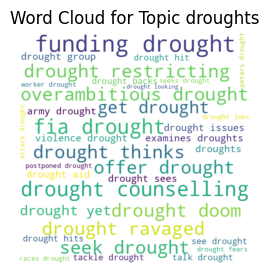

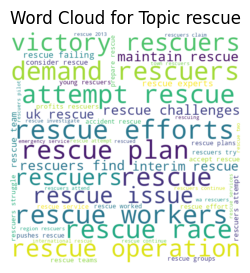

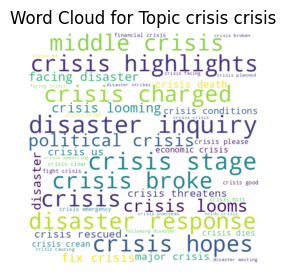

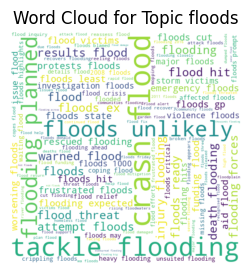

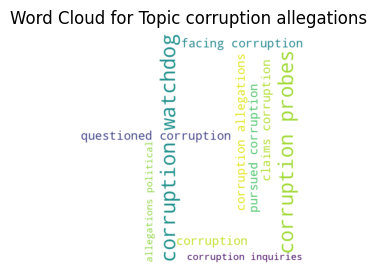

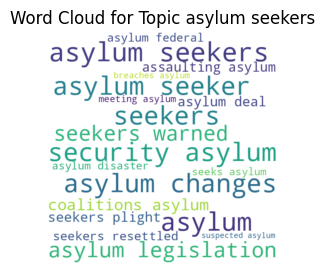

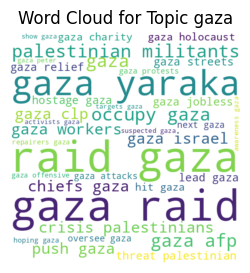

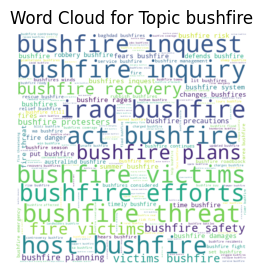

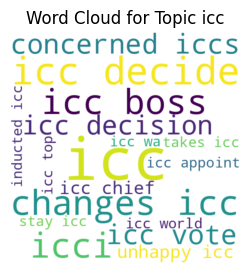

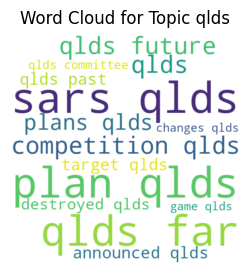

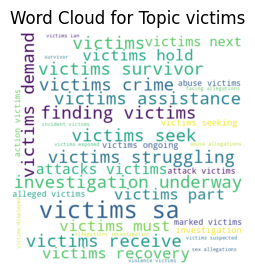

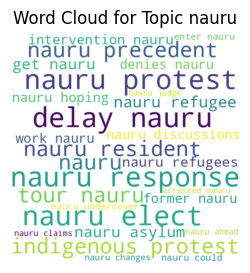

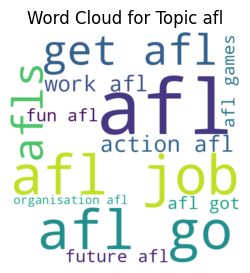

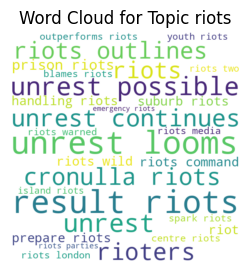

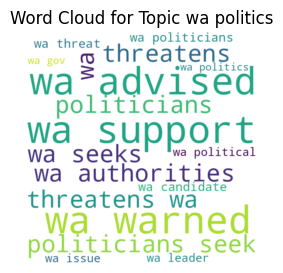

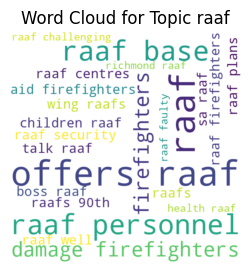

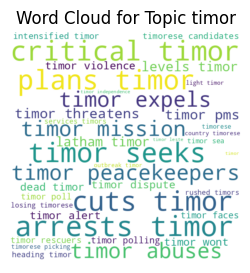

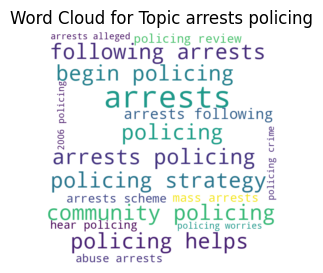

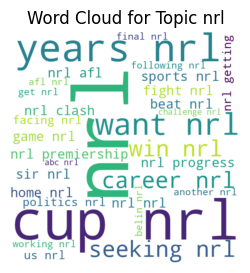

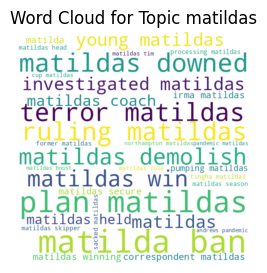

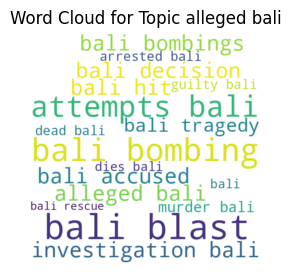

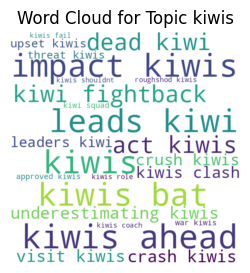

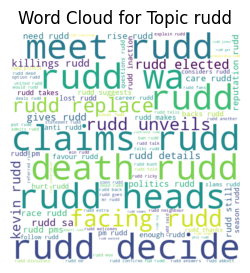

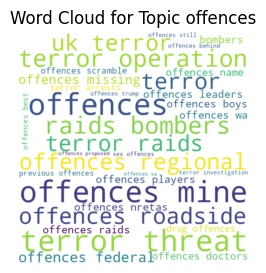

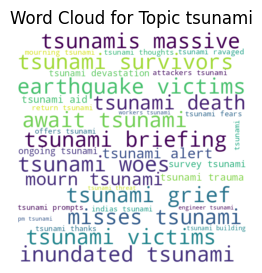

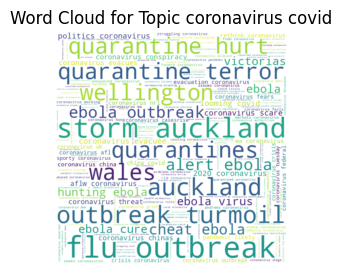

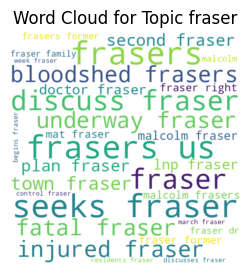

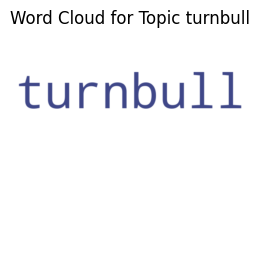

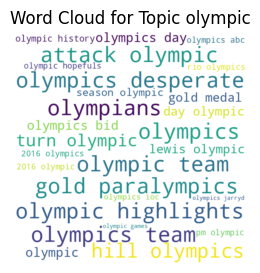

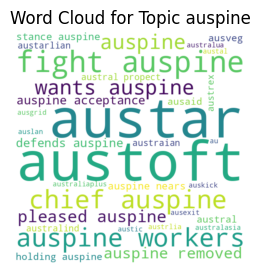

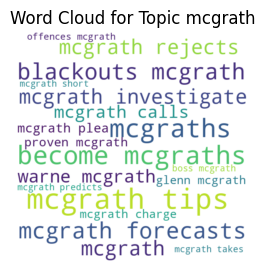

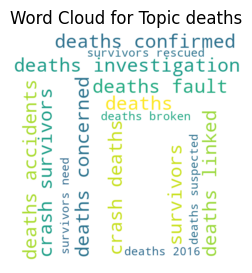

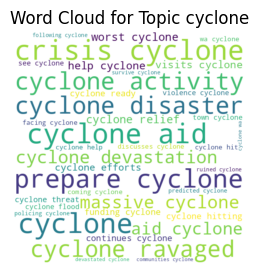

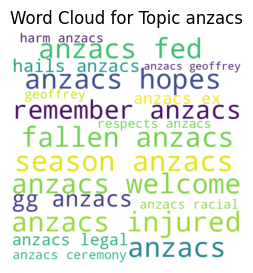

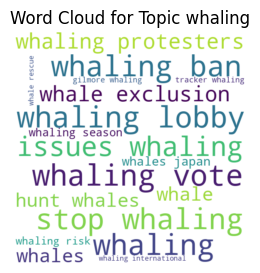

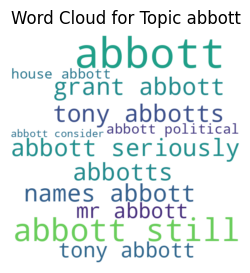

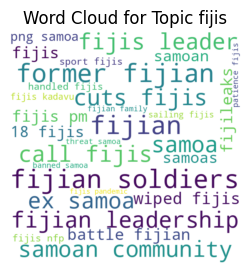

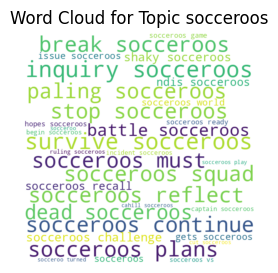

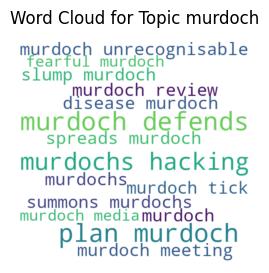

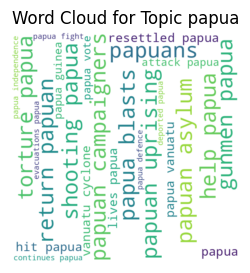

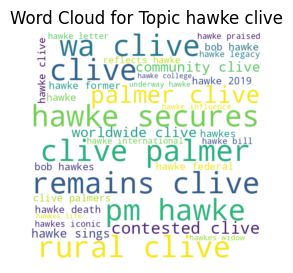

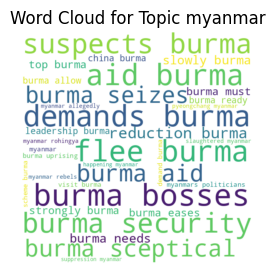

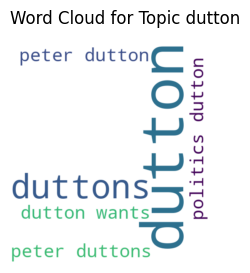

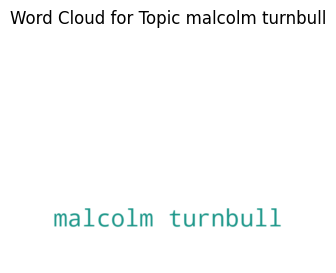

In [ ]:
# ===========================
# Visualization
# ===========================

# Generate Word Clouds for Each Topic
for cluster, words in cluster_keywords.items():
    # Create a word cloud for each topic
    word_freq = {word: words.count(word) for word in words}
    wordcloud = WordCloud(width=600, height=600, background_color="white").generate_from_frequencies(word_freq)

    # Plot word cloud
    plt.figure(figsize=(3, 3))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Word Cloud for Topic {cluster_labels[cluster]}")
    plt.axis('off')
    plt.show()

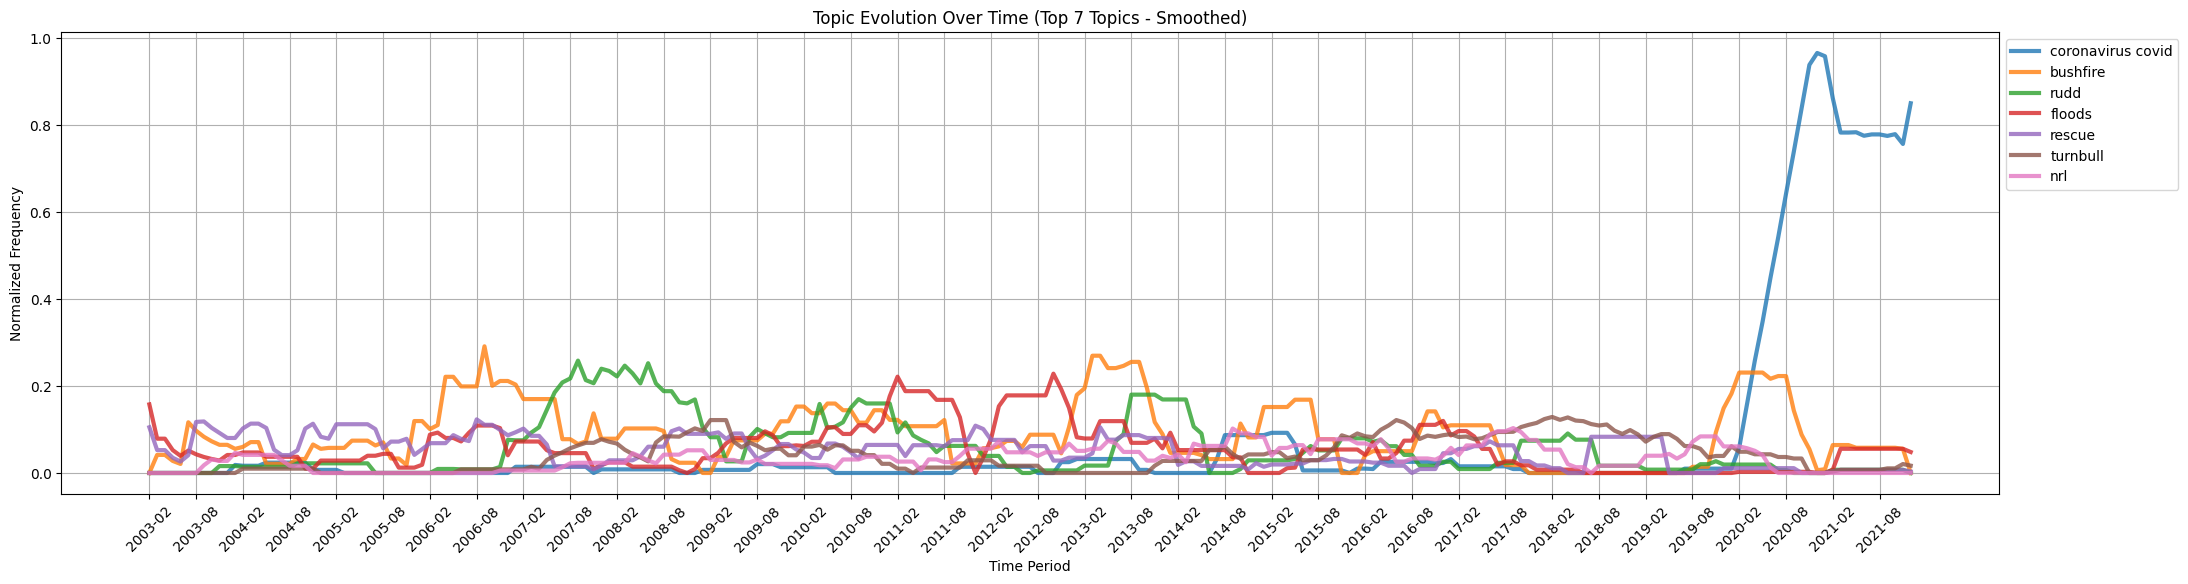

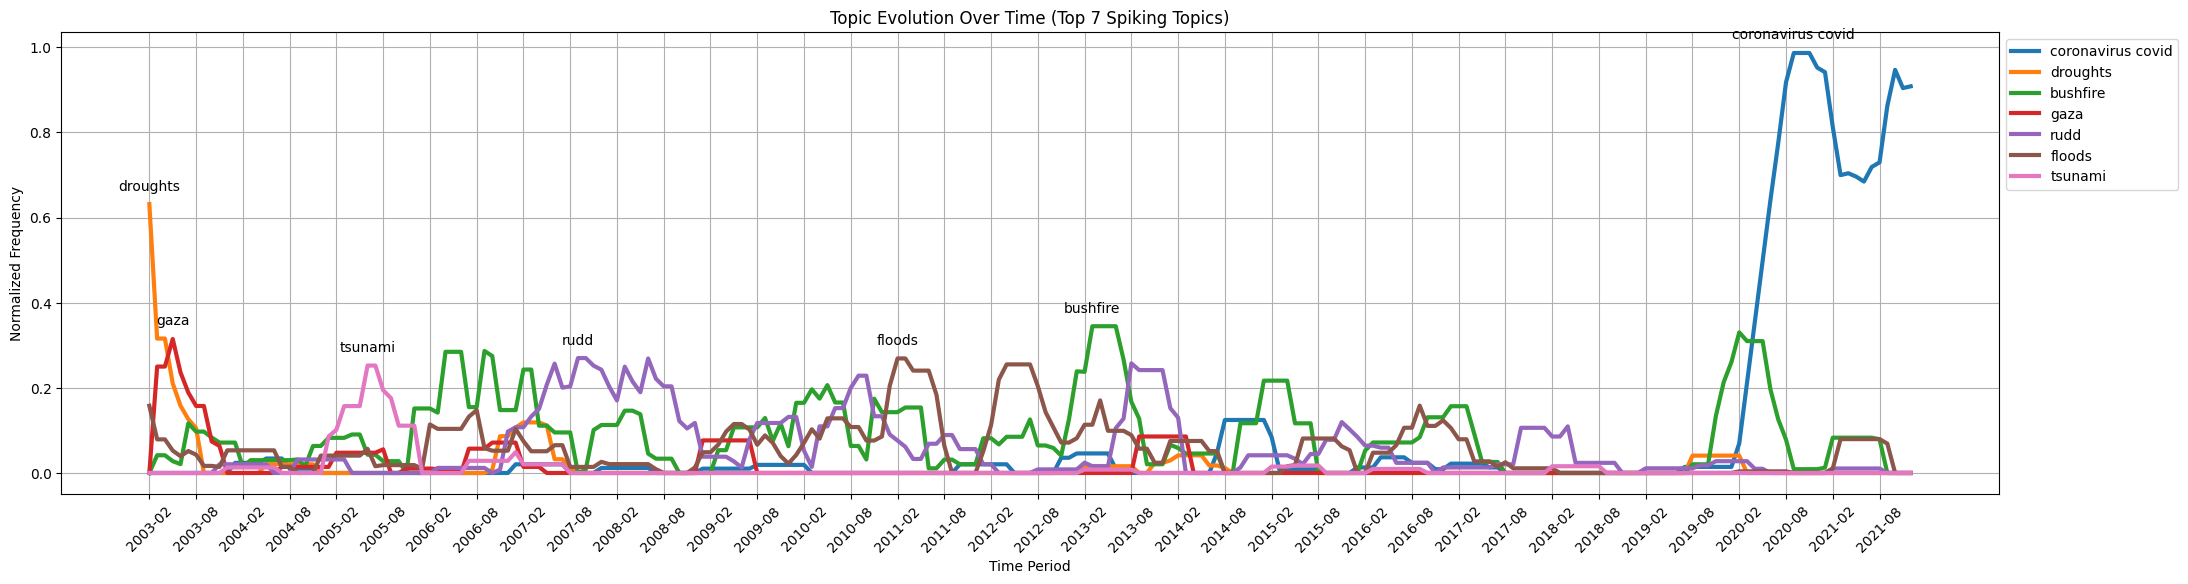

In [ ]:
# ===========================
# Visualization
# ===========================

# Visualizing Topic Evolution Over Time with Smoothed Lines
# Apply rolling average for smoother trends
dtm_df_smoothed = dtm_df.rolling(window=10, min_periods=1).mean()

# Select top 10 most frequent topics
top_topics = dtm_df.sum().sort_values(ascending=False).head(7).index.tolist()

plt.figure(figsize=(25, 6))

# Highlight persistent topics
for topic in top_topics:
    plt.plot(dtm_df_smoothed.index, dtm_df_smoothed[topic], linewidth=3, label=topic, alpha=0.8)

plt.xlabel('Time Period')
plt.ylabel('Normalized Frequency')
plt.title('Topic Evolution Over Time (Top 7 Topics - Smoothed)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Move legend outside for better clarity
#plt.xticks(rotation=45)
# Show only every 6th month
plt.xticks(ticks=dtm_df_smoothed.index[::6], labels=dtm_df_smoothed.index[::6], rotation=45)
plt.grid(True)
plt.show()

# ===========================
# Select Topics with Major Spikes in Popularity
# ===========================

# 1.
# # spiking def 1
# # Compute the mean and standard deviation for each topic
# topic_means = dtm_df.mean()
# topic_stds = dtm_df.std()

# # Identify topics that had significant spikes (more than 1 standard deviation above mean)
# spiking_topics = []
# for topic in dtm_df.columns:
#     if (dtm_df[topic] > (topic_means[topic] + topic_stds[topic])).any():
#         spiking_topics.append(topic)

# spiking def 2
# Compute percentage change over time
dtm_df_change = dtm_df.pct_change().fillna(0)

# Define spiking topics as those exceeding a 100% increase in any period
spiking_topics = dtm_df_change.columns[(dtm_df_change > 1.0).any()].tolist()

# Select only those topics
dtm_df_filtered = dtm_df[spiking_topics]

# Apply rolling average for smoother trends
dtm_df_smoothed = dtm_df_filtered.rolling(window=7, min_periods=1).mean()

# ===========================
# Visualization: Topic Evolution Over Time (Top 10 Spiking Topics)
# ===========================

# Identify the top 10 spiking topics (based on max frequency)
top_spiking_topics = dtm_df_smoothed.max().sort_values(ascending=False).head(7).index.tolist()

plt.figure(figsize=(25, 6))

# Plot each of the top 7 spiking topics
for topic in top_spiking_topics:
    plt.plot(dtm_df_smoothed.index, dtm_df_smoothed[topic], linewidth=3, label=topic)
    max_idx = dtm_df_smoothed[topic].idxmax()  # Get peak time
    max_val = dtm_df_smoothed[topic].max()
    plt.annotate(topic, (max_idx, max_val), textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel('Time Period')
plt.ylabel('Normalized Frequency')
plt.title('Topic Evolution Over Time (Top 7 Spiking Topics)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Move legend outside for clarity

# Improve x-axis readability: Show only every 6th month
plt.xticks(ticks=dtm_df_smoothed.index[::6], labels=dtm_df_smoothed.index[::6], rotation=45)

plt.grid(True)
plt.show()

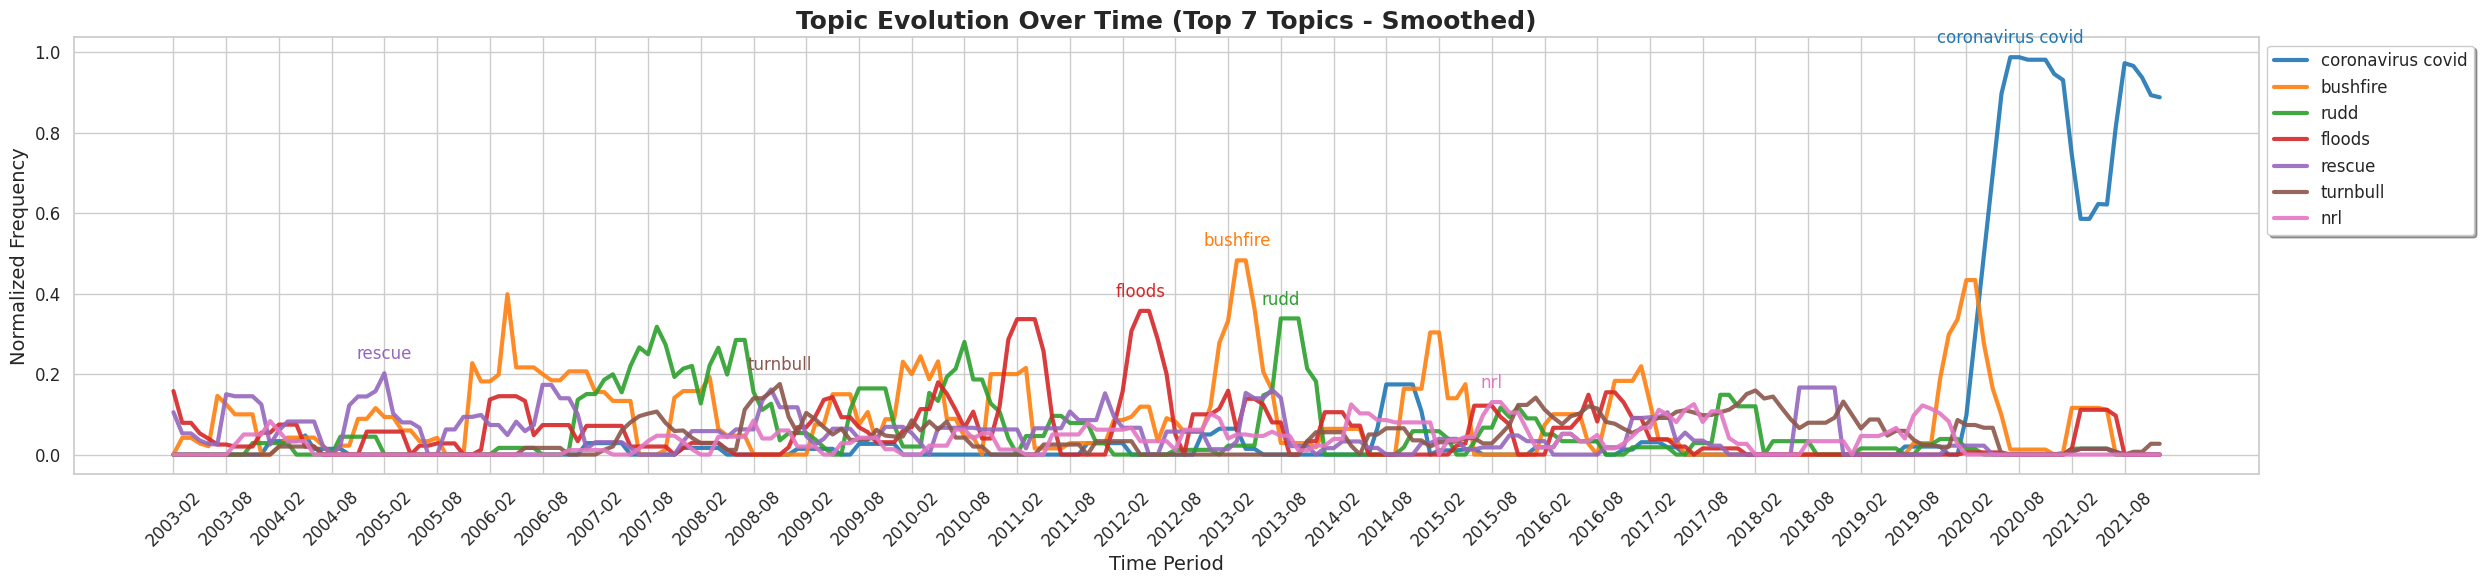

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use a seaborn theme for a modern look
sns.set_theme(style="whitegrid")

# Apply rolling average for smoother trends
dtm_df_smoothed = dtm_df.rolling(window=5, min_periods=1).mean()

# Select top 6 most frequent topics
top_topics = dtm_df.sum().sort_values(ascending=False).head(7).index.tolist()

# Create a larger, high-resolution figure
plt.figure(figsize=(25, 6), dpi=100)

# Generate color palette
colors = sns.color_palette("tab10", len(top_topics))  # tab10 provides distinct colors

# Plot each of the top topics with smooth lines
lines = []
for topic, color in zip(top_topics, colors):
    line, = plt.plot(
        dtm_df_smoothed.index,
        dtm_df_smoothed[topic],
        linewidth=3,
        label=topic,
        alpha=0.9,
        color=color  # Apply assigned color
    )
    lines.append(line)  # Store lines for legend formatting

    max_idx = dtm_df_smoothed[topic].idxmax()
    max_val = dtm_df_smoothed[topic].max()
    plt.annotate(
        topic, (max_idx, max_val),
        textcoords="offset points", xytext=(0,10),
        ha='center', fontsize=12, color=color  # Set annotation color
    )

# Format axis labels and title
plt.xlabel('Time Period', fontsize=14)
plt.ylabel('Normalized Frequency', fontsize=14)
plt.title('Topic Evolution Over Time (Top 7 Topics - Smoothed)', fontsize=18, fontweight='bold')

# Create a color-matching legend
plt.legend(handles=lines, loc='upper left', bbox_to_anchor=(1, 1), fontsize=12, frameon=True, shadow=True)

# Optimize x-axis tick labels
plt.xticks(
    ticks=dtm_df_smoothed.index[::6],
    labels=dtm_df_smoothed.index[::6],
    rotation=45,
    fontsize=12
)
plt.yticks(fontsize=12)

# Show grid and adjust layout
plt.grid(True)
plt.tight_layout()

plt.show()


In [ ]:
# Interactive plot

import plotly.graph_objects as go

# Create interactive figure
fig = go.Figure()

# Add traces (lines) for each topic
for topic in top_spiking_topics:
    fig.add_trace(go.Scatter(
        x=dtm_df_smoothed.index,
        y=dtm_df_smoothed[topic],
        mode='lines',  # Smooth lines
        name=topic,  # Topic name appears in legend
        line=dict(width=3),  # Thicker lines
    ))

# Customize layout
fig.update_layout(
    title="Topic Evolution Over Time (Interactive)",
    xaxis_title="Time Period",
    yaxis_title="Normalized Frequency",
    legend_title="Topics",
    hovermode="x",  # Show data on hover
    template="plotly_white",  # Clean background
)

# Show interactive plot
fig.show()
